In [133]:
import pylab as pl
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from lines import lines
from desispec.io import read_frame, read_spectra
from redrock.templates import find_templates, Template
from astropy.table import Table
from desispec.resolution import Resolution
from desispec.interpolation import resample_flux
from astropy.convolution import convolve, Box1DKernel

In [94]:
skyline=np.array([5199.4,5578.4,5656.4,5891.4,5897.4,6302.4,6308.4,6365.4,6500.4,6546.4,\
                  6555.4,6618.4,6663.4,6679.4,6690.4,6765.4,6831.4,6836.4,6865.4,6925.4,\
                  6951.4,6980.4,7242.4,7247.4,7278.4,7286.4,7305.4,7318.4,7331.4,7343.4,\
                  7360.4,7371.4,7394.4,7404.4,7440.4,7526.4,7714.4,7719.4,7752.4,7762.4,\
                  7782.4,7796.4,7810.4,7823.4,7843.4,7855.4,7862.4,7873.4,7881.4,7892.4,\
                  7915.4,7923.4,7933.4,7951.4,7966.4,7982.4,7995.4,8016.4,8028.4,8064.4,\
                  8280.4,8284.4,8290.4,8298.4,8301.4,8313.4,8346.4,8355.4,8367.4,8384.4,\
                  8401.4,8417.4,8432.4,8454.4,8467.4,8495.4,8507.4,8627.4,8630.4,8634.4,\
                  8638.4,8652.4,8657.4,8662.4,8667.4,8672.4,8677.4,8683.4,8763.4,8770.4,\
                  8780.4,8793.4,8829.4,8835.4,8838.4,8852.4,8870.4,8888.4,8905.4,8922.4,\
                  8945.4,8960.4,8990.4,9003.4,9040.4,9052.4,9105.4,9227.4,9309.4,9315.4,\
                  9320.4,9326.4,9340.4,9378.4,9389.4,9404.4,9422.4,9442.4,9461.4,9479.4,\
                  9505.4,9521.4,9555.4,9570.4,9610.4,9623.4,9671.4,9684.4,9693.4,9702.4,\
                  9714.4,9722.4,9740.4,9748.4,9793.4,9802.4,9814.4,9820.4])

In [6]:
templates = {}

for filename in find_templates():
    t       = Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [35]:
zbest = Table.read('/project/projectdirs/desi/spectro/redux/cascades/tiles/80606/deep/zbest-0-80606-deep.fits')
fmap  = Table.read('/project/projectdirs/desi/spectro/redux/cascades/tiles/80606/deep/zbest-0-80606-deep.fits', 'FIBERMAP')

In [38]:
coadd = read_spectra('/project/projectdirs/desi/spectro/redux/cascades/tiles/80606/deep/coadd-0-80606-deep.fits')

In [49]:
rr_z  = zbest['Z']
tids  = zbest['TARGETID']

spectype = [x.strip() for x in zbest['SPECTYPE']]
subtype  = [x.strip() for x in zbest['SUBTYPE']]

fulltype = list(zip(spectype, subtype))

In [13]:
ncoeff = [templates[ft].flux.shape[0] for ft in fulltype]
coeff = [x[0:y] for (x,y) in zip(zbest['COEFF'], ncoeff)]

In [44]:
tfluxs = [templates[ft].flux.T.dot(cf).tolist()     for (ft, cf) in zip(fulltype, coeff)]
twaves = [(templates[ft].wave * (1. + rz)).tolist() for (ft, rz) in zip(fulltype, rr_z)]

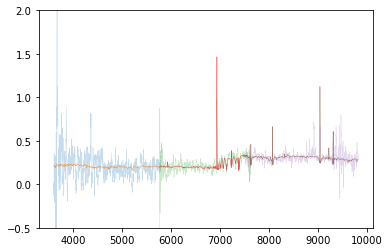

In [92]:
for tid, tflux, twave in zip(tids, tfluxs, twaves):
    assert (np.count_nonzero(coadd.fibermap['TARGETID'] == tid) == 1)
     
    for band in ['b', 'r', 'z']:    
        flux = coadd.flux[band][coadd.fibermap['TARGETID'] == tid][0]
        
        # 0.8 A pix. 
        flux = convolve(flux, Box1DKernel(15), boundary='extend')
                
        rflux = resample_flux(coadd.wave[band], twave, tflux)
        
        pl.plot(coadd.wave[band], flux, lw=0.5, alpha=0.25)
        pl.plot(coadd.wave[band], rflux, lw=0.5, alpha=0.75)

        pl.ylim(-0.5, 2.)
        
    break

In [93]:
lines.pprint(max_lines=-1, max_width=-1)

 LINEID      WAVELENGTH          NAME     REDSHIFT GROUP WIDTH GROUP FLUX GROUP SCALE FACTOR INDEX GROUP DOUBLET LINERATIO MASKED
-------- ------------------ ------------- -------------- ----------- ---------- ------------ ----- ----- ------- --------- ------
emlineid            1215.67      Ly_alpha          z_lya      w_ly_a      f1215          1.0     0     0     -99       0.0      0
emlineid            1240.81      N_V 1240      zemission       w_n_v      f1240          1.0     1     2     -99       0.0      0
emlineid            1549.48     C_IV 1549      zemission   wemission      f1549          1.0     2     3     -99       0.0      1
emlineid            1640.42    He_II 1640      zemission   wemission      f1640          1.0     3     3     -99       0.0      0
emlineid           1908.734   C_III] 1908      zemission   wemission      f1908          1.0     4     3     -99       0.0      0
emlineid  2800.315188621943    Mg_II 2799      zemission   wemission      f2799          1

In [118]:
hw   = 2.

In [119]:
wave = coadd.wave['z']
mask = np.ones_like(coadd.wave['z'])

In [120]:
for line in skyline:
    if line<=wave[0] or line>=wave[-1]:
        continue

    ii=np.where((wave>=line-hw)&(wave<=line+hw))[0]

    mask[ii]=0.0

In [121]:
np.mean(mask)

0.822283929191253

In [126]:
zs = np.arange(0.0, 2.5, 1.e-4)
mask = np.ones_like(zs)

In [125]:
wavea = 3727.0917225096655 * (1. + zs)
waveb = 3729.8754437612800 * (1. + zs)

In [127]:
for line in skyline:
    for wave in [wavea, waveb]:
        if line<=wave[0] or line>=wave[-1]:
            continue

        ii=np.where((wave>=line-hw)&(wave<=line+hw))[0]

        mask[ii]=0.0

In [128]:
np.mean(mask)

0.89224

Text(0, 0.5, 'Radial mask [2.0A half width]')

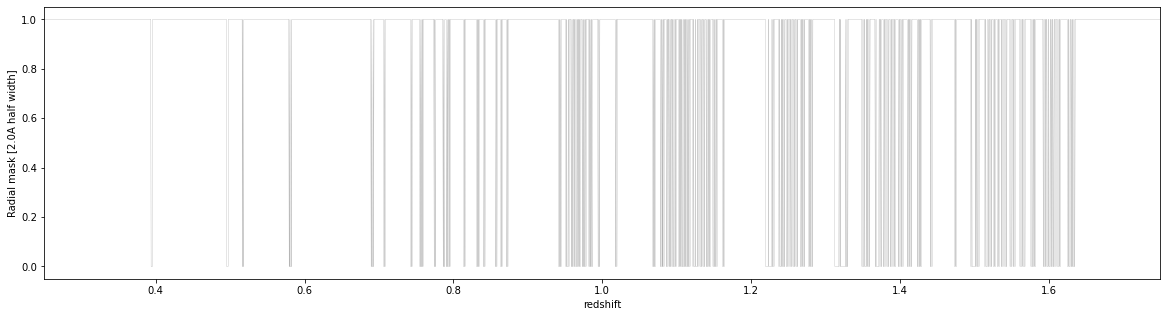

In [143]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(zs, mask, c='k', lw=0.1)
ax.set_xlim(0.25, 1.75)

pl.xlabel('redshift')
pl.ylabel('Radial mask [{:.1f}A half width]'.format(hw))

# Done.